# Goal of this notebook

Extract the 'essence' of a prompt based on the "CLIP-guided image essence transfer" paper (https://arxiv.org/abs/2110.12427). 
The approach: optimize a latent vector in the space of the image generation network in such a way, that it:
 1. maximizes the features for the target prompt when added to the source image
 2. is consistent over a set of refernce images. Meaning: for each reference image combination, the cosine similarity between the change in CLIP features induced by optimized latent vector should be minimized
    
## Alternative approach:

This 'direction' might be applicable for StyleGAN latent space, which are quite specialized on a certain domain of images, but might not easily work for big latent spaces such as the one of VQGAN. Therefore, we can try to induce a similar behaviour by using vector arithmetic in the CLIP latent space. If the essence vector of "sad" extracted using the technique above is A, it might also be recoverable by something like: CLIP("This is a sad painting") - CLIP("This is a painting") = A.

We can visualize A from both techniques, either by itself or when added to some image latent.

In [ ]:
import os
import sys
sys.path.append("../StyleCLIP_modular")
from style_clip import Imagine, create_text_path

In [ ]:
args = dict()
#args["model_type"] = "stylegan"
args["model_type"] = "vqgan"


prefix_sg3_pkl = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/"
#args["style"] = prefix_sg3_pkl + "stylegan3-t-ffhq-1024x1024.pkl"
args["style"] = prefix_sg3_pkl + "stylegan3-t-metfaces-1024x1024.pkl"
#"../stylegan3/sg3_madziowa_p_240.pkl"

args["sideX"] = 128
args["sideY"] = 128
args["iterations"] = 500
args["clip_names"] = ["ViT-B/16", "ViT-B/32"]
args["batch_size"] = 8
args["lr_schedule"] = 0
if args["model_type"] == "stylegan":
    args["lr"] = 0.003 
else:
    args["lr"] = 0.1

imagine = Imagine(
                save_progress=False,
                open_folder=False,
                save_video=False,
                verbose=False,
                **args
               )

In [ ]:
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image

@torch.inference_mode()
def get_base_latents_stylegan(imagine, num=10):
    sg = imagine.model.model
    
    z = torch.from_numpy(np.random.RandomState().randn(num, sg.model.z_dim)).to(imagine.device)
    base_latents = sg.model.mapping(z,  None, truncation_psi=1.0)
    
    base_imgs = [sg(latents=l.unsqueeze(0)) for l in base_latents]
    return base_latents, base_imgs


@torch.inference_mode()
def get_base_latents_vqgan(imagine, num=10):
    root_folder = "base_images"
    img_list = ["Autumn_1875_Frederic_Edwin_Church.jpg", "carmen_cute.png", "hot-dog.jpg",
               "earth.jpg", "carmen_cute.png", "joni_model.png", "michi_san_diego.jpg"]
    img_list = img_list[:num]
    imgs = [Image.open(os.path.join(root_folder, i)).convert("RGB") for i in img_list]
    
    model = imagine.model.model
    transform = T.Compose([
                    T.Resize(min(model.sideY, model.sideX)),
                    T.CenterCrop((model.sideY, model.sideX)),
                    T.ToTensor()])
    base_imgs = [transform(img).unsqueeze(0) for img in imgs]

    base_latents = [model.model.encode(img.to(model.device).mul(2).sub(1))[0] for img in base_imgs]
    base_imgs = [model(latents=l) for l in base_latents]
    return base_latents, base_imgs

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
imagine.reset()
start_latent = imagine.get_latent().clone().detach()

In [ ]:
import random

from IPython.display import display
import torchvision
from style_clip.clip import spherical_dist_loss
from tqdm.auto import tqdm


target_text = "Sadness" #"Pure anger and fury can be seen in the face"
target_img = None # "base_images/joni_model.png"
lam = 0.1 #0.005 # 4
num_base_imgs = 6 # 2 for stylegan
# set target
imagine.set_clip_encoding(text=target_text, img=target_img)
# define img transforms
clip_resize = lambda x: torch.nn.functional.interpolate(x, size=224, mode='bilinear')
clip_norm = imagine.perceptor.norm
to_pil = torchvision.transforms.ToPILImage()
# set base imgs
if args["model_type"] == "stylegan":
    base_latents, base_imgs = get_base_latents_stylegan(imagine, num=num_base_imgs)
else:
    base_latents, base_imgs = get_base_latents_vqgan(imagine, num=num_base_imgs)
display(to_pil(base_imgs[0].squeeze(0)).resize(size=(64, 64)))
# calc start clip and start img gen latent features
with torch.no_grad():
    base_start_img_feats = [imagine.perceptor.encode_image(clip_norm(clip_resize(img))) for img in base_imgs]

try:
    pbar = tqdm(range(args["iterations"]))
    for i in pbar:
        current_latent = imagine.get_latent()
        if i == 0:
            direction = current_latent - start_latent
        else:
            direction = current_latent - rand_lat

        # here we should not only optimize one latent, but rather many
        rand_idx = random.randint(0, len(base_latents) - 1)
        rand_lat = base_latents[rand_idx]
        imagine.set_latent(rand_lat + direction)
        out, clip_loss = imagine.model.forward(imagine.clip_encoding, neg_text_embed=imagine.clip_neg_encoding)
        clip_loss.backward()


        shifted_base_latents = [l + direction for l in base_latents]
        base_shifted_imgs = [imagine.model.model(latents=l) for l in shifted_base_latents]
        #base_shifted_imgs.append(out)
        # calc difference direction vectors in CLIP latent space between clip feats of base+direction against base
        base_shifted_img_feats = [imagine.perceptor.encode_image(clip_norm(clip_resize(img))) for img in base_shifted_imgs]
        base_feat_diff = [[shifted_feat[i] - start_feat[i] for i in range(len(start_feat))] 
                          for start_feat, shifted_feat in zip(base_start_img_feats, base_shifted_img_feats)]
        # show img
        if i % 20 == 0:
            size = 128
            #with torch.inference_mode():
            #    dir_pil = to_pil(imagine.model.model(latents=direction).squeeze(0)).resize(size=(size, size))
            #display(dir_pil)
            out_pil = to_pil(out.squeeze(0).detach()).resize(size=(size, size))
            display(out_pil)
            for shifted_img in base_shifted_imgs:
                shifted_pil = to_pil(shifted_img.squeeze(0).detach()).resize(size=(size, size))
                display(shifted_pil)
            print()

        # calc consistency loss, enforcing all direction vectors in CLIP latent space to be the same
        consistency_loss = 0
        if i > 0:
            for diff_1 in base_feat_diff:
                for diff_2 in base_feat_diff:
                    if diff_1 is diff_2:
                        continue
                    losses = [spherical_dist_loss(d_1, d_2) for d_1, d_2 in zip(diff_1, diff_2)]
                    #print(losses)
                    loss = torch.stack(losses).mean()
                    consistency_loss += loss

            consistency_loss = consistency_loss * lam #+ clip_loss

            pbar.set_description(f"DirMag: {direction.pow(2).mean().item()} Cons loss: {round(consistency_loss.item(), 3)} CLIP loss: {round(clip_loss.item(), 3)}")

            consistency_loss.backward()
        imagine.optimizer.step()
        imagine.optimizer.zero_grad()
except KeyboardInterrupt:
    pass

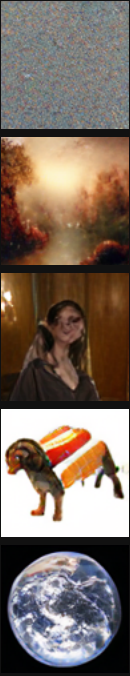

transforms to with cons loss of 0.1:

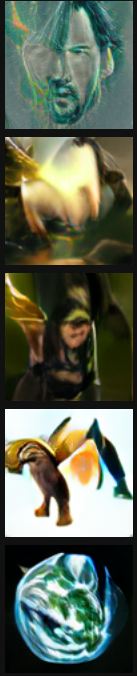

with more imgs from

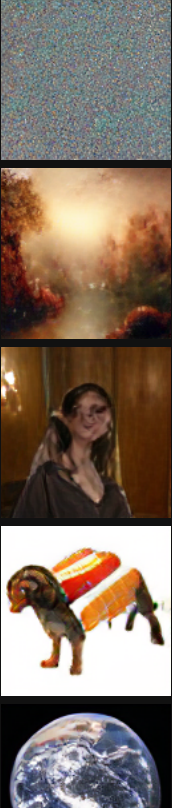

to 

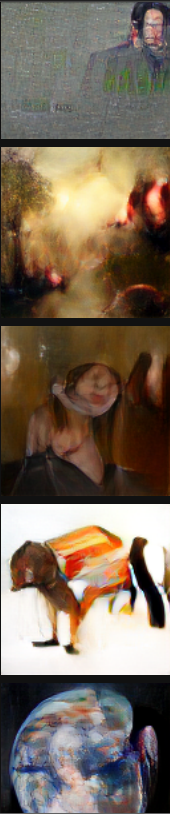

to

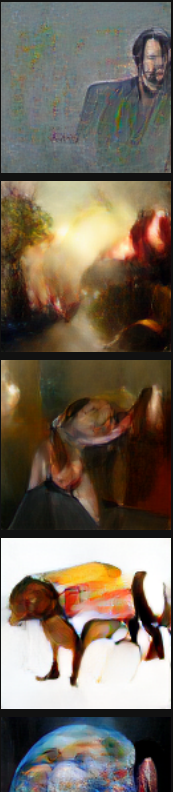

changing "Keanu Reeves" to "sad" leads to:

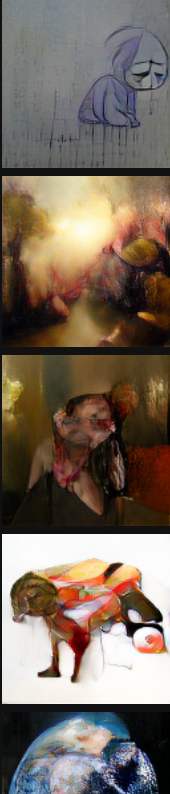


Now I changed that not only one image is optimized towards the target prompt, but a random one of the source images instead (might be even better to opt multiple in a batch).

We start with:
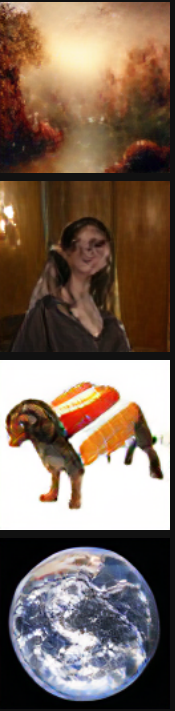

and it changes into

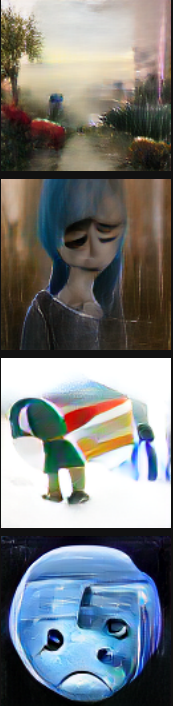

In [ ]:
# test direction vqqgan with different test images.  apply it in different strengths
root_folder = "base_images"
test_img_list = ["angels/benmoran_angel_of_wings.jpg", "angels/naomi_baker_wings.jpg",
                 "florka_bilder/florka_beach.jpeg", "fritzkola/wahrheit_einhorn.jpg", 
                 "aicpa_logo_purple.jpg"]
test_imgs = [Image.open(os.path.join(root_folder, i)).convert("RGB") for i in test_img_list]

model = imagine.model.model
transform = T.Compose([
                T.Resize(min(model.sideY, model.sideX)),
                T.CenterCrop((model.sideY, model.sideX)),
                T.ToTensor()])
test_imgs = [transform(img).unsqueeze(0) for img in test_imgs]

test_latents = [model.model.encode(img.to(model.device).mul(2).sub(1))[0] for img in test_imgs]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(len(test_latents)):
    test_latent = test_latents[i]
    for alpha in np.arange(0, 3, 1.0):
        test_latent_shifted = test_latent + direction * alpha
        out = imagine.model.model(latents=test_latent_shifted)
        plt.imshow(to_pil(out.squeeze().detach().cpu()))
        plt.axis("off")
        plt.title(f"Alpha {alpha}")
        plt.show()

In [ ]:
1 + 1

In [ ]:
# first replicate with stylegan
def get_dir_stylegan(imagine, img=img, text=text, lame=0.7):
    pass

In [ ]:
# Now apply to VQGAN